# Chapter 9. Root Finding and Nonlinear Sets of Equations

1. [Bisection](#Bracketing-and-Bisection)
2. [Secant](#Secant-Method)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline
plt.ioff()


When then solution or solutions of equation $f(x)=0$ are desired, namely to find the root or roots of a function. In vector notation, we want to find one or more N-dimesional solution vectors $\textbf{x}$ such that $\textbf{f(x)}=\textbf{0}$.

In [2]:
x = np.linspace(-5, 5, 500)
x_axis = np.zeros(x.shape)


In [3]:
def plot_f(f, show=False):
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 1, 1))
    ax.plot(x, f(x))
    ax.plot(x, x_axis)
    if show:
        plt.show(fig)
    return ax, fig


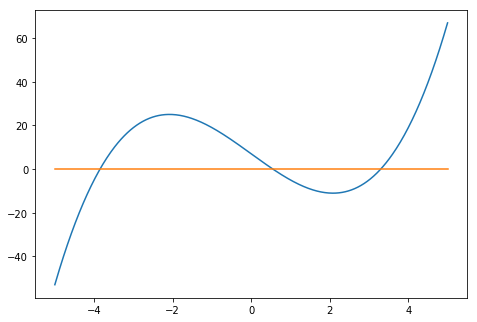

(<matplotlib.axes._axes.Axes at 0x208bbe08e80>,
 <matplotlib.figure.Figure at 0x208bbe087f0>)

In [4]:
poly_f = lambda x: x ** 3 - 13 * x + 7
plot_f(poly_f, True)


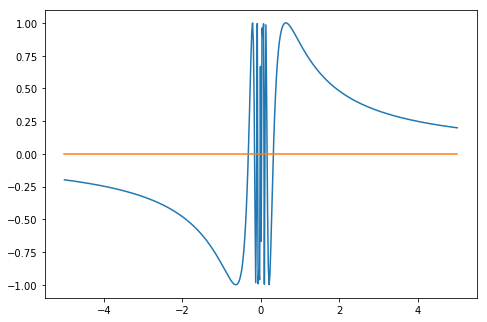

(<matplotlib.axes._axes.Axes at 0x208bbf4e780>,
 <matplotlib.figure.Figure at 0x208bbf0f048>)

In [5]:
sin_inv_f = lambda x: np.sin(1 / x)
plot_f(sin_inv_f, True)


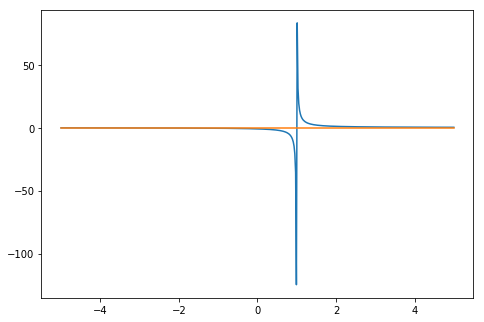

(<matplotlib.axes._axes.Axes at 0x208bb162f60>,
 <matplotlib.figure.Figure at 0x208bc0eca20>)

In [6]:
inv_f = lambda x: 1 / (x - 1)
plot_f(inv_f, True)


## Bracketing and Bisection

If $f(a)$ and $f(b)$ have opposite signs, then at least one root must lie in that interval (the intermediate value theorem). Evaluate the function at the interval's midpoint and examine its sign. Use the midpoint to replace whichever limit has the same sign. After each iteration the bounds containing the root decrease by a factor of two. If after $n$ iterations the root is known to be within an interval of size 

$$\epsilon_{n+1} = \frac{\epsilon_{n}}{2}$$

Thus, we know in advance the number of iterations requiered to achieve a given tolerance in the solution.

$$n=\log_{2}\frac{\epsilon_0}{\epsilon}$$

In [7]:
def bisection(a, b, f, tol, max_itr=None):
    hist = []
    # a and b must have opposite signs
    assert f(a) * f(b) < 0
    if max_itr is None:
        max_itr = int(np.linalg.norm(np.log2(abs(a - b) / tol))) + 2
    if (f(a) >= 0):
        pos = a
        neg = b
    else:
        neg = a
        pos = b
    for i in range(max_itr):
        hist.append([[pos, f(pos)], [neg, f(neg)]])
        if abs(f(pos) - f(neg)) > tol:
            med = (pos + neg) / 2
            if (f(med) > 0):
                pos = med
            else:
                neg = med
        else:
            return pos, hist, i
    print("exceeds the maximal iterations")
    return pos, hist, max_itr


In [8]:
def create_ani(fig, animate):
    animation = FuncAnimation(fig, animate, frames=20, interval=1000)
    return HTML(animation.to_html5_video())


In [9]:
def create_f_ani(a, b, f):
    r, hist, itr = bisection(a, b, f, 10 ** -10, 50)
    print(r, itr)
    ax, fig = plot_f(f)
    scat = ax.scatter((a, b), (f(a), f(b)))
    def update(frame_number):
        scat.set_offsets(hist[frame_number])
        return (scat,)
    return create_ani(fig, update)


In [10]:
create_f_ani(-4, -2, poly_f)


-3.84947157464012 40


In [11]:
create_f_ani(2, 4, poly_f)


3.298117179005203 39


In [12]:
create_f_ani(-2, 1, sin_inv_f)


0.3183098861882172 39


In [13]:
create_f_ani(-1, 2, inv_f)


exceeds the maximal iterations
1.0000000000000009 50


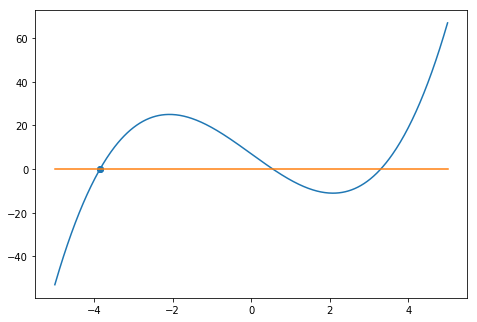

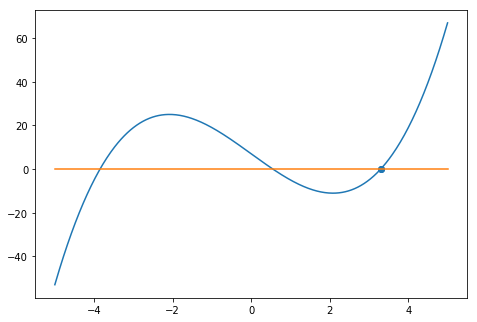

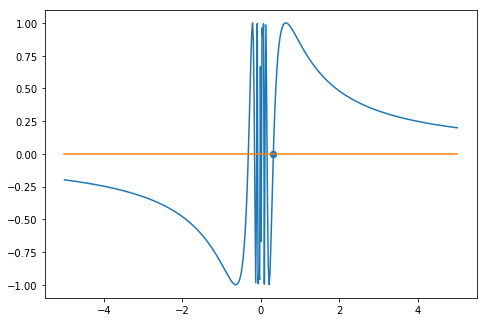

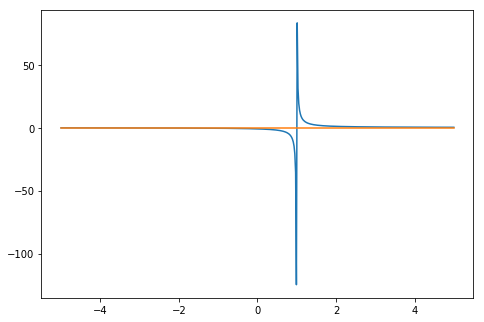

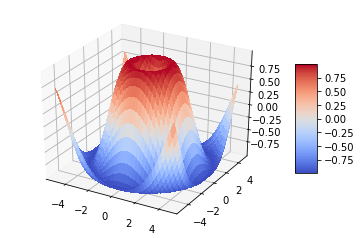

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, X)
f_2dim = lambda x: np.sin(np.sqrt(np.sum(x ** 2, axis=0)))
Z = f_2dim(np.vstack((X.reshape(1, -1), Y.reshape(1, -1)))).reshape(X.shape)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [15]:
pos, hist, max_itr = bisection(np.array([[-4], [2]]), np.array([[2], [0]]), f_2dim, 10 ** -10)
print(pos)
print(np.asscalar(f_2dim(pos)))


[[-2.71935677]
 [ 1.57311892]]
8.597446122402249e-11


## Secant Method